In [1]:
#!kaggle competitions download -c house-prices-advanced-regression-techniques

In [2]:
# import zipfile
# with zipfile.ZipFile("house-prices-advanced-regression-techniques.zip", "r") as zip_ref:
#     zip_ref.extractall("house")

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact,fixed
import cufflinks as cf
import plotly.offline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

np.warnings.filterwarnings('ignore')
cf.go_offline()
cf.set_config_file(offline=False,world_readable=True)

### 1. Import the data files

In [4]:
train = pd.read_csv("house\\train.csv")
test = pd.read_csv("house\\test.csv")

### 2. Exploratory Data Analysis

In [5]:
integer_columns = train.columns[train.dtypes != object]
@interact
def scatter_plot(x =integer_columns[1:-1], 
                 y =fixed(integer_columns[-1]), 
                 theme = list(cf.themes.THEMES.keys()),
                colorscale = list(cf.colors._scales_names.keys()), 
                 x_axis=widgets.IntSlider(min=500,max=700),
                y_axis=widgets.IntSlider(min=400,max=500)):
    train.iplot(kind='scatter', x=x, y=y, mode='markers',
                   xTitle=x.title(), yTitle=y.title(), dimensions =(x_axis,y_axis),
                   title = f'{y.title()} vs {x.title()} {round(train[x].corr(train[y]),4)}',
                    theme=theme, colorscale=colorscale)

interactive(children=(Dropdown(description='x', options=('MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual'…

In [6]:
categorical_columns = train.columns[train.dtypes == object]
@interact
def scatter_plot(x =categorical_columns[:-1], y =fixed('SalePrice'),
                 theme = list(cf.themes.THEMES.keys()),
                colorscale = list(cf.colors._scales_names.keys()),
                 x_axis=widgets.IntSlider(min=500,max=700),
                y_axis=widgets.IntSlider(min=400,max=500)):
    train.iplot(kind='bar', x=x,y=y,bargap =.1, dimensions =(x_axis,y_axis),
                xTitle=x.title(), yTitle=y.title(),
                title = f'{x.title()}', theme=theme, colorscale=colorscale)
    print(train[x].value_counts())

interactive(children=(Dropdown(description='x', options=('MSZoning', 'Street', 'Alley', 'LotShape', 'LandConto…

### 3. Handle Missing data

In [7]:
col_with_NA = train.columns[train.isnull().sum() > 0]
@interact
def explore_data(column = col_with_NA):
    num_of_NA = train[column].isnull().sum()
    perc_of_NA = round(100*num_of_NA/train.shape[0], 2)
    print ("Number of NA's {}".format(num_of_NA), 
           ": Percentage of NA's {}%".format(perc_of_NA))

interactive(children=(Dropdown(description='column', options=('LotFrontage', 'Alley', 'MasVnrType', 'MasVnrAre…

In [8]:
train_len = train.shape[0]
test_len = test.shape[0]
target = train['SalePrice']
full_data = pd.concat((train, test), sort=False).reset_index(drop=True)
full_data.drop(['SalePrice'], axis=1, inplace=True)
full_data.drop(['Id'], axis=1, inplace=True)

In [9]:
full_data['LotFrontage'] = full_data.LotFrontage.fillna(full_data.LotFrontage.median())
full_data['GarageYrBlt'] = full_data.GarageYrBlt.fillna(9999)
full_data['MasVnrArea'] = full_data.MasVnrArea.fillna(0)
full_data['Electrical'] = full_data.Electrical.fillna(method='ffill')

In [10]:
for col in full_data.columns:
    if full_data[col].dtype == "object":
        full_data[col] = full_data[col].fillna("None")

In [11]:
full_data.isnull().sum().sum()

10

In [12]:
for col in full_data.columns:
    if full_data[col].dtype != "object":
        full_data[col] = full_data[col].fillna(0)

In [13]:
full_data.isnull().sum().sum()

0

### 4. Feature Engineering

In [14]:
full_data['MoSold'] = full_data['MoSold'].astype(str)
full_data['MSSubClass'] = full_data['MSSubClass'].apply(str)

In [15]:
full_data = pd.get_dummies(full_data)

In [16]:
train = full_data[:train_len]
test = full_data[test_len:]

### 5. Outlier Detection & Correction

In [17]:
# from scipy import stats
# def detectOutlier(data):
#     z = np.abs(stats.zscore(data))
#     return z

In [18]:
# train['SalePrice'] = target
# train = train[(detectOutlier(train) < 3).all(axis=1)]
# detectOutlier(train)

In [19]:
# test = test[(detectOutlier(test) < 3).all(axis=1)]
# detectOutlier(test)

In [20]:
# target = train['SalePrice']
# train.drop(['SalePrice'], axis=1, inplace=True)

### 6. Cross validation

In [21]:
from sklearn.model_selection import cross_validate

In [23]:
def val_error(cv):
    return -cv['test_score'].mean()

In [24]:
def poly_model(degree):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        LinearRegression(fit_intercept=True),
    )

In [43]:
def cv(model):
    return cross_validate(model, train, target, scoring='neg_mean_squared_error', cv=5, return_train_score=True)


In [68]:
models = pd.DataFrame({
    'name': ['Linear', 'Quadratic',],
    'model': [poly_model(1), poly_model(2),],
})

In [73]:
models['cv'] = models['model'].apply(cv)
models['val_error'] = models['cv'].apply(val_error)

,name,model,cv,val_error
0,Linear,"(PolynomialFeatures(degree=1, include_bias=Fal...","{'fit_time': [0.16899442672729492, 0.163000822...",1.333728e+09
1,Quadratic,"(PolynomialFeatures(include_bias=False), Linea...","{'fit_time': [42.927998542785645, 44.498000860...",3.607738e+10


In [74]:
models

,name,model,cv,val_error
0,Linear,"(PolynomialFeatures(degree=1, include_bias=Fal...","{'fit_time': [0.16899442672729492, 0.163000822...",1.333728e+09
1,Quadratic,"(PolynomialFeatures(include_bias=False), Linea...","{'fit_time': [42.927998542785645, 44.498000860...",3.607738e+10


In [80]:
def get_train_errs(models):
    return models['cv'].apply(lambda cv: -cv['train_score'])

def get_valid_errs(models):
    return models['cv'].apply(lambda cv: np.log(-cv['test_score']))

def make_errors(models, errs):
    return (pd.DataFrame.from_dict(dict(zip(errs.index, errs.values)))
            .melt(var_name='index', value_name='mse')
            .merge(models[['name']], left_on='index', right_index=True))

def plot_errors(errors, log=False, err_type='Training'):
    plt.figure(figsize=(8, 4))
    sns.pointplot('name', 'mse', ci='sd', data=errors)
    plt.xlabel('Model')
    plt.ylabel('log(mse)' if log else 'mse')
    plt.title(f'{err_type} Error')

In [81]:
errors = make_errors(models, get_train_errs(models))
#plot_errors(errors, log=False, err_type='Training')
print(errors)

   index           mse       name
0      0  4.086376e+08     Linear
1      0  3.486604e+08     Linear
2      0  3.157902e+08     Linear
3      0  4.089486e+08     Linear
4      0  3.962601e+08     Linear
5      1  9.151821e-11  Quadratic
6      1  1.290834e-10  Quadratic
7      1  2.087789e-09  Quadratic
8      1  8.753398e-11  Quadratic
9      1  1.090510e-11  Quadratic


In [82]:
errors.shape

(10, 3)

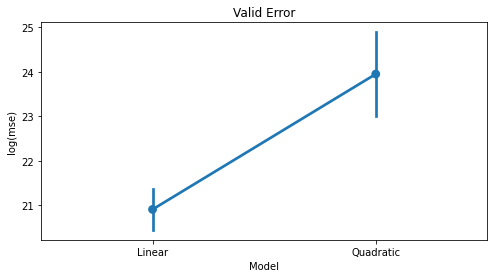

In [83]:
errors = make_errors(models, get_valid_errs(models))
plot_errors(errors, log=True, err_type='Valid')